# PLEASE ONLY RUN THE NEXT FOUR CELLS ONCE!

## Google Colab Runtime Configuration
**Before running any cells, please change the runtime version:**
1. Go to **Edit** → **Notebook Settings** → **Runtime Version** 
2. Select **2025.07** 
3. Click **Save**

## Important Notes:
- The setup cells below will install dependencies and may cause kernel restarts
- This is expected behavior - simply continue after each restart
- Only run the setup cells once per session

In [1]:
# Global variable to check if we're in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ! pip install numpy==1.26.4
    ### The runtime will crash/restart after this

In [2]:
# Global variable to check if we're in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

  !pip install -q condacolab #-U "git+https://github.com/mayankchetan/condacolab.git@py312update"
  import condacolab
  condacolab.install() #### expect a kernel restart

In [3]:
# Global variable to check if we're in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone  https://github.com/wisdem/weis
    !git clone https://github.com/mayankchetan/weisWorkshop

    %cd weis
    !conda config --env --add pinned_packages "numpy<2.0"
    !mamba env update -n base -f environment.yml "python<3.13"
    %pip install .
    %cd ..
    %pip install "rosco==2.9.5"
    %pip install -U "git+https://github.com/NREL/ROSCO@v2.9.7"
    %pip install "orbit-nrel<1.2.2"
    %pip install gdown

else:
    try:
        import weis

    except ImportError:
        raise ImportError("Please install the weis package from https://github.com/wisdem/weis in the environment you are using to run this notebook.")

    Warning("Make sure you have cloned 'https://github.com/mayankchetan/weisWorkshop-Private' repository and are running the notebook from the root directory of the repository.")


Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.

In [4]:
# Downloading the precomputed data from Google Drive & extracting
# Drive link for non Google Colab users: https://drive.google.com/file/d/145BH393nzpT2msCVsHSBxR3Qy8KdpddI/view?usp=sharing
if IN_COLAB:
    !gdown 145BH393nzpT2msCVsHSBxR3Qy8KdpddI -O /content/weisWorkshop/archive_weisWorkshop_OCT25.tar.gz
    !tar -xvzf /content/weisWorkshop/archive_weisWorkshop_OCT25.tar.gz -C /content/weisWorkshop/
else:
    print("Please download the precomputed data from the link given in the notebook and extract it in the root directory of the repository.")
    print("you can use `tar -xvzf <downloaded_file_name>` to extract the files.")

Please download the precomputed data from the link given in the notebook and extract it in the root directory of the repository.
you can use `tar -xvzf <downloaded_file_name>` to extract the files.


# Welcome to the WEIS Workshop - Chapter 1: Rotor Design and Optimization

## Introduction

WEIS is a comprehensive framework that performs multifidelity co-design of wind turbines by integrating multiple NREL-developed tools:

- **WISDEM** (Wind-Plant Integrated System Design and Engineering Model) - A set of models for assessing overall wind plant cost of energy (COE) using wind turbine and plant cost, energy production, and financial models
- **OpenFAST** - A physics-based engineering tool for simulating the coupled dynamic response of wind turbines, including aero-hydro-servo-elastic simulation in the time domain
- **ROSCO** (Reference OpenSource Controller) - An open, modular, and fully adaptable baseline wind turbine controller with industry-standard functionality
- **RAFT** (Response Amplitudes of Floating Turbines) - A frequency-domain analysis tool for floating wind turbines

These tools work together in a unique workflow to enable comprehensive wind turbine design optimization, from individual components to full system integration.

## Workshop Objectives

In this workshop, you are tasked with designing and optimizing a **20MW floating wind turbine** starting from the IEA 22MW reference turbine. Your objectives include:

1. **Establish baseline performance** - Understand the IEA 22MW floating turbine characteristics and performance
2. **Scale and optimize the rotor** - Modify the rotor to achieve 20MW rating while optimizing aerodynamic and structural performance
3. **Optimize the controller** - Retune the ROSCO pitch controller for the new rotor design to ensure optimal performance
4. **Design the floating platform** - Optimize a semisubmersible platform to support the turbine under various load conditions
5. **Validate through load analysis** - Simulate the design according to IEC Design Load Case (DLC) analysis

## Our Systematic Multi-Stage Approach 

We'll follow a systematic optimization approach that mirrors our wind turbine development practices:

1. **IEA 22MW Baseline** - Start with the IEA 22MW floating turbine to establish a reference point
2. **Rotor Scaling and Optimization** - Scale the rotor diameter for 20MW rating, then optimize chord, twist, and structural properties using WISDEM
3. **Controller Re-tuning** - Use ROSCO to re-tune the controller for optimal performance with the modified rotor
4. **Floating Platform Optimization** - Use RAFT for frequency-domain optimization of the semisubmersible platform
5. **High-Fidelity Integration** - Refine the design using OpenFAST for coupled aero-hydro-servo-elastic optimization
6. **Design Validation** - Conduct comprehensive DLC analysis to verify the final design meets all requirements


<!-- This staged approach offers several advantages:
- **Manageable complexity** - Build complexity gradually rather than solving one massive optimization problem
- **Appropriate fidelity** - Use the right tool for each design phase (fast tools for initial sizing, high-fidelity for final validation)
- **Better convergence** - Smaller, focused optimization problems are more likely to converge successfully
- **Educational value** - Understand how different subsystems interact and influence overall performanc -->


In [5]:
if IN_COLAB:
    # Now we try loading the weis_workshop module again
    sys.path.append('/content/weisWorkshop/jupyterNotebooks')

# Importing nesscary libraries.
import numpy as np
import matplotlib.pyplot as plt
from weis import weis_main
from wisdem import run_wisdem
import os
import copy
import pandas as pd

from weis_workshop import *

# workshop repository folder
if IN_COLAB:
    WORKSHOP_REPO = '/content/weisWorkshop'
else:
    WORKSHOP_REPO = os.path.join(os.getcwd(), '..')

Running in local environment


In [7]:
WORKSHOP_REPO

'/Users/dzalkind/Tools/WEIS-Eni/examples/09_model_creation_process/0_notebooks/..'

## Stage 0: Establishing a Baseline

Let's start by running the IEA 22MW floating turbine to understand our starting point. Since we're designing a 20MW turbine, the IEA22MW reference gives us a good baseline that's close to our target size.

In [10]:
# Setting up file paths
stageFolder = "stage-0-baseline"

fname_wt_input = os.path.join(WORKSHOP_REPO, "..", "00_setup", "ref_turbines", "IEA-22-280-RWT_Floater.yaml")
fname_modeling_options = os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "stage-0-baseline_modeling.yaml")
fname_analysis_options = os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "stage-0-baseline_analysis.yaml")


## Understanding the Input Files

**For Google Colab users:** Use the file browser on the left to navigate to the cloned repository and open the YAML files (double click).

### Turbine Geometry File (WindIO Format)
The turbine is defined using WindIO format. Here are the key sections:

```yaml
name: IEA 22MW Offshore Wind Turbine in Floating Configuration
assembly:
    turbine_class: I
    turbulence_class: B
    drivetrain: direct_drive
    rotor_orientation: Upwind
    number_of_blades: 3
    hub_height: 170.0
    rotor_diameter: 284.0
    rated_power: 22000000.0
    lifetime: 25.0
components:
  blade:
    outer_shape_bem:
      reference_axis:
        x: { grid: [...], values: [...] }
        y: { grid: [...], values: [...] }
        z: { grid: [...], values: [...] }
      chord: { grid: [...], values: [...] }
      twist: { grid: [...], values: [...] }
    internal_structure_2d_fem:
      reference_axis: [...]
      layers: [...]
      webs: [...]
  hub:
    diameter: 7.94  # m
    cone_angle: -2.5  # degrees
    
  nacelle:
    drivetrain: [...]
    transformer: [...]
    
  tower:
    outer_shape_bem: [...]
    internal_structure_2d_fem: [...]
    
  mooring:
    nodes: [...]
    lines: [...]
airfoils: [...]
materials: [...]
controls: [...]
environment: [...]
bos: [...]
costs: [...]
```

### Analysis and Modeling Options
These files control what WEIS calculates and how:

**Analysis Options** (How to analyze the problem):
```yaml
general:
    folder_output: outputs/
    fname_output: stage-0-baseline
```

**Modeling Options** (which tools to use):
```yaml
General:
    verbosity: False

WISDEM:
    RotorSE:
        flag: True
    TowerSE:
        flag: True
    DriveSE:
        flag: True
    FloatingSE:
        flag: True
    BOS:
        flag: True

OpenFAST: # Options for WEIS fidelity level 3 = nonlinear time domain
    flag: False

RAFT:
    flag: False

ROSCO:
    flag: True
    tuning_yaml: ../source/iea22_rosco.yaml
```


In [13]:
# lets overide a few things so that we dont distrupt the existing results.
analysis_override = {}
analysis_override['general'] = {}
analysis_override['general']['folder_output'] = 'outputsCh1'


iea22mw, modeling_options, opt_options = weis_main(fname_wt_input, 
                                                 fname_modeling_options, 
                                                 fname_analysis_options,
                                                 analysis_override=analysis_override,
                                                 test_run=False
                                                 )


wisdem.wt.wt_rna


NL: NLBGS 1 ; 5.81491099e+11 1


NL: NLBGS 2 ; 1207363.87 2.07632391e-06


NL: NLBGS 3 ; 5643.76806 9.70568263e-09
NL: NLBGS Converged


UHC input: [0.] -- Mass: [0.]


ORBIT library intialized at '/Users/dzalkind/miniforge3/envs/weis-eni/lib/python3.11/site-packages/library'
Cp-Ct-Cq surfaces completed at 5 %
Cp-Ct-Cq surfaces completed at 10 %
Cp-Ct-Cq surfaces completed at 15 %
Cp-Ct-Cq surfaces completed at 20 %
Cp-Ct-Cq surfaces completed at 25 %
Cp-Ct-Cq surfaces completed at 30 %
Cp-Ct-Cq surfaces completed at 35 %
Cp-Ct-Cq surfaces completed at 40 %
Cp-Ct-Cq surfaces completed at 45 %
Cp-Ct-Cq surfaces completed at 50 %
Cp-Ct-Cq surfaces completed at 55 %
Cp-Ct-Cq surfaces completed at 60 %
Cp-Ct-Cq surfaces completed at 65 %
Cp-Ct-Cq surfaces completed at 70 %
Cp-Ct-Cq surfaces completed at 75 %
Cp-Ct-Cq surfaces completed at 80 %
Cp-Ct-Cq surfaces completed at 85 %
Cp-Ct-Cq surfaces completed at 90 %
Cp-Ct-Cq surfaces completed at 95 %
Cp-Ct-Cq surfaces completed at 100 %
-----------------------------------------------------------------------------
   Tuning a reference wind turbine controller using NREL's ROSCO toolbox    
-----------------

Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.

----------------
Design Variables
----------------
name  val  size  
----  ---  ---- 

-----------
Constraints
-----------
name  val  size  
----  ---  ---- 

----------
Objectives
----------
name  val  size  
----  ---  ---- 

Run time (outputsCh1): 24.042563915252686


In [16]:
# Lets analyize the baseline design!!
baseline_turb = pd.read_csv(os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "outputsCh1/stage-0-baseline.csv"), index_col=0)
# Open the CSV file shown above so explore the various variables output from WISDEM/WEIS

print(f'there are {len(baseline_turb.index)} variables in the baseline design:')

baseline_turb.index 

there are 4691 variables in the baseline design:


Index(['sse_tune.v_min', 'sse_tune.v_max', 'sse_tune.r', 'sse_tune.chord',
       'sse_tune.theta', 'sse_tune.Rhub', 'sse_tune.Rtip',
       'sse_tune.hub_height', 'sse_tune.precone', 'sse_tune.tilt',
       ...
       'rotorse.rs.strains.axial_root_sparU_load2stress',
       'rotorse.rs.strains.axial_root_sparL_load2stress',
       'rotorse.rs.strains.axial_maxc_teU_load2stress',
       'rotorse.rs.strains.axial_maxc_teL_load2stress',
       'rotorse.rs.tip_pos.tip_deflection', 'rotorse.rs.tot_loads_gust.Px_af',
       'rotorse.rs.tot_loads_gust.Py_af', 'rotorse.rs.tot_loads_gust.Pz_af',
       'rotorse.stall_check.no_stall_constraint',
       'rotorse.stall_check.stall_angle_along_span'],
      dtype='object', name='variables', length=4691)

WEIS outputs a comprehensive set of variables about the wind turbine analysis - you can see there are hundreds of them!

Here are the key variables we'll focus on for understanding the baseline design:
- `rotorse.rp.powercurve.V` → Wind speed (m/s)
- `rotorse.rp.powercurve.Cp_aero` → Power coefficient 
- `rotorse.rp.powercurve.Ct_aero` → Thrust coefficient
- `rotorse.rp.powercurve.P` → Power (W)
- `rotorse.rp.powercurve.T` → Thrust (N)
- `rotorse.rp.powercurve.pitch` → Pitch angle (deg)

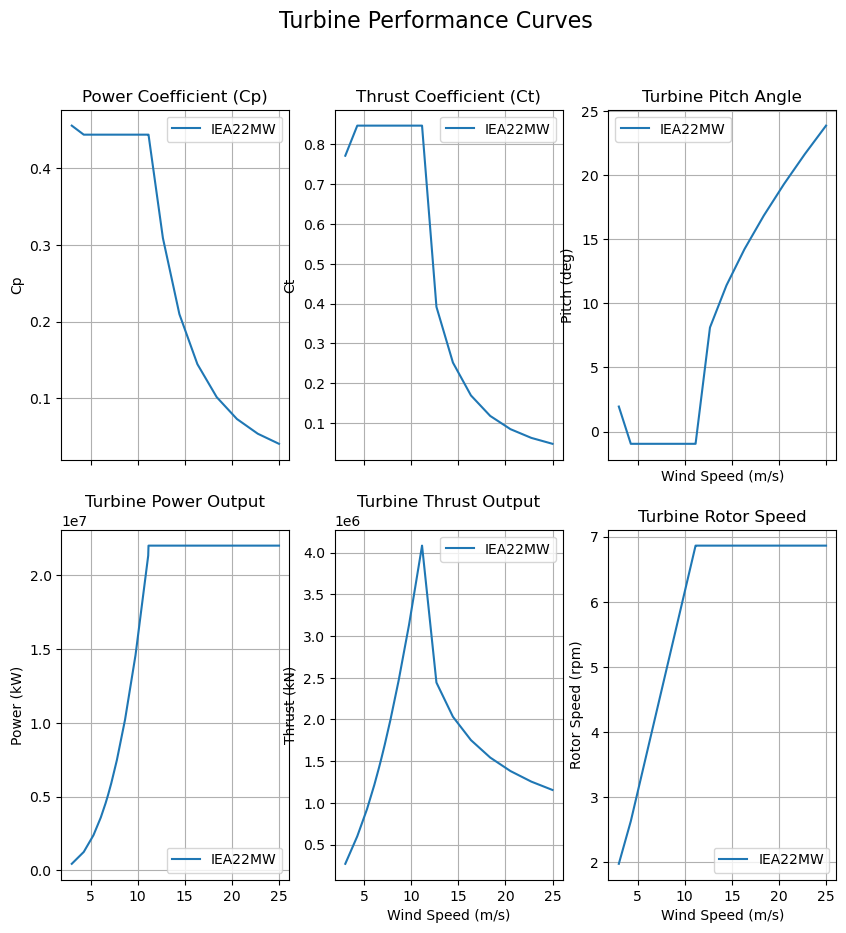

In [17]:
plot_comparison_plot(baseline_turb, label='IEA22MW')

## Something Looks Off......

At first glance, the power curve looks reasonable, but notice the Cp values. The IEA 22MW is known to achieve ~0.49, but our plot shows ~0.45. What's happening?

`The IEA 22MW is highly flexible with significant blade torsion. Our analysis uses CCBlade, which assumes rigid blades and misses the flexibility effects. For accurate performance, we'd need OpenFAST with BeamDyn (the high-fidelity blade model), but that's computationally expensive.`

For this initial design and optimization phase, CCBlade gives us the right trends even if the absolute values aren't perfect.

## Converting the IEA 22MW to a 20MW

Now let's create our 20MW turbine by scaling the IEA 22MW. We will calculate a new diameter to ensure the same specific power (W/m²) in the new 20 MW rotor.

The power equation for a wind turbine rotor is:

$$P = \frac{1}{2} \rho A V^3 C_p$$

Where:
- $P$ = power (W)
- $\rho$ = air density (kg/m³)
- $A = \pi D^2/4$ = rotor swept area (m²)
- $V$ = wind speed (m/s)  
- $C_p$ = power coefficient

For scaling, we assume $\rho$, $V$, and $C_p$ remain constant. This gives us:

$$\frac{P_{20MW}}{P_{22MW}} = \frac{A_{20MW}}{A_{22MW}} = \frac{D_{20MW}^2}{D_{22MW}^2}$$

Solving for the new diameter:

$$D_{20MW} = D_{22MW} \sqrt{\frac{P_{20MW}}{P_{22MW}}} = 284.0 \times \sqrt{\frac{20}{22}} \approx 270.0 \text{ m}$$

Here's the updated geometry file with the scaled values:

``` yaml
assembly:
    turbine_class: I
    turbulence_class: B
    drivetrain: direct_drive
    rotor_orientation: Upwind
    number_of_blades: 3
    hub_height: 170.0
    rotor_diameter: 270.0 # 284.0
    rated_power: 20000000.0 # 22000000.0
    lifetime: 25.0
```

# Stage 1: Rotor Optimization

Now that we have a baseline and the new 20MW geometry file, let's optimize the rotor design. 

We'll use WISDEM for this rotor optimization rather than the more complex OpenFAST+Controller approach. This gives us a quick first-pass optimization that's computationally efficient. This approach also demonstrates how we systematically use multiple tools in the optimization process, avoiding a single massive optimization problem that can be difficult to solve.

In [24]:
# Setting up file paths, and defining the WEIS overide for this stage
stageFolder = "stage-1-aeroStruct"

fname_wt_input = os.path.join(WORKSHOP_REPO, "2_models", "new-20-270-RWT_Floater_v2p0.yaml")
fname_modeling_options = os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "stage-1-aeroStruct_modeling.yaml")
fname_analysis_options = os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "stage-1-aeroStruct_analysis.yaml")

# fname_wt_input = os.path.join(WORKSHOP_REPO, "..", "00_setup", "ref_turbines", "IEA-22-280-RWT_Floater.yaml")
# fname_modeling_options = os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "stage-0-baseline_modeling.yaml")
# fname_analysis_options = os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder, "stage-0-baseline_analysis.yaml")

# We dont have analysis, and modeling options overrides in WISDEM
# analysis_override = {}
# analysis_override['general'] = {}
# analysis_override['general']['folder_output'] = 'outputsCh1'
# analysis_override['driver'] = {}
# analysis_override['driver']['max_iter'] = 1 # only run one iteration for this demo, we have precomputed the solutions for you :)

## Examining the Input Files

### Google Colab Users:
1. Go to the file browser on the left
2. Navigate to the cloned repository
3. Open the YAML files to examine the configuration

## Analysis Options:
The analysis options file defines what we want to optimize and the constraints we need to satisfy. Here are the key sections:

```yaml

design_variables:
 
    blade:
        aero_shape:
            twist:
                flag: False # Flag to optimize the twist
                inverse: True # Flag to determine twist from a desired angle of attack
                inverse_target: 'max_efficiency' # Twist generates angles of attack # corresponding to 'max_efficiency' or 'stall_margin'
                n_opt: 10 # Number of control points along blade span. During inverse design, # twist is smoothened with a spline with these
                max_decrease: 0.08722222222222221 # Maximum decrease for the twist in [rad] at the n_opt locations. Only used if flag is set to True
                max_increase: 0.08722222222222221 # Maximum increase for the twist in [rad] at the n_opt locations. Only used if flag is set to True
                index_start: 2 # Lock the first two DVs from blade root
                index_end: 10 # All DVs close to blade tip are active

            chord:
                flag: True # Flag to optimize the chord
                n_opt: 10 # Number of control points along blade span
                max_decrease: 0.4 # Minimum multiplicative gain on existing chord at the n_opt locations
                max_increase: 1.5 # Maximum multiplicative gain on existing chord at the n_opt locations
                index_start: 1 # Lock the first DV from blade root
                index_end: 9 # All DVs close to blade tip are active
            af_positions:
                flag: True
                af_start: 4
        structure:
            - layer_name: spar_cap_ss
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked
            - layer_name: spar_cap_ps
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked
            - layer_name: te_reinforcement_ss
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked
            - layer_name: te_reinforcement_ps
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked

# figure of merit
merit_figure: LCOE

constraints:
    blade:
        stall:
            flag: False # Constraint on minimum stall margin
            margin: 0.12 # Value of minimum stall margin in [rad]
        chord:
            flag: True # Constraint max chord to its default value (4.75 m)
            max: 8. # Max chord value
        chord_slope:
            flag: True # Constraint to enforce monothonically decreasing chord after max chord
        root_circle_diameter:
            flag: False # Constraint for the minimum blade root circle diameter
            max_ratio: 1.2 # The recommended value can be up to 20% larger than the actual
        moment_coefficient:
            flag: False # Constraint on maximum blade root flapwise moment coefficient
            max: 0.20 # Lowering this value will lead to low induction rotors
        strains_spar_cap_ss:
            flag: True         # Flag to impose constraints on maximum strains (absolute value) in the spar cap on the blade suction side
            max:    3500.e-6   # Value of maximum strains [-]
            index_start: 1     # Do not enforce constraint at the first station from blade root of the n_opt from spar_cap_ss
            index_end: 7       # Do not enforce constraint at the last station at blade tip of the n_opt from spar_cap_ss
        strains_spar_cap_ps:
            flag: True         # Flag to impose constraints on maximum strains (absolute value) in the spar cap on the blade pressure side
            max:    3500.e-6   # Value of maximum strains [-]
            index_start: 1     # Do not enforce constraint at the first station from blade root of the n_opt from spar_cap_ps
            index_end: 7       # Do not enforce constraint at the last station at blade tip of the n_opt from spar_cap_ps      
        tip_deflection:
            flag: True
            margin: 1.4175

driver:
    optimization:
        flag: True          # Flag to enable optimization
        tol: 1.e-6          # Optimality tolerance
        max_iter: 1000      # Maximum number of iterations (SLSQP)
        solver: SLSQP       # Optimization solver. Other options are 'SLSQP' - 'CONMIN'
        step_size: 1.e-3    # Step size for finite differencing
        form: central       # Finite differencing mode, either forward or central

recorder:
    flag: True              # Flag to activate OpenMDAO recorder
    file_name: log_opt.sql  # Name of OpenMDAO recorder


```

## Modeling Options:
The modeling options file controls which WISDEM modules are active during the optimization:

```yaml
General:
    verbosity: True  # When set to True, the code prints to screen many infos


WISDEM:
    RotorSE:
        flag: True
        spar_cap_ss: spar_cap_ss
        spar_cap_ps: spar_cap_ps

    DriveSE:
        flag: False
    TowerSE:
        flag: True
    FloatingSE:
        flag: False
    BOS:
        flag: False

```

## 1.1: Configuration Check

**Before running the optimization, please verify these settings:**

1. **Output path**: Update the analysis options file to set output path to `outputsCh1`
2. **Iteration limit**: Set `max_iter` to `1` (we'll use precomputed results for this demonstration)

These modifications ensure the demo runs quickly while preserving your existing output files.

In [25]:

wt_opt, modeling_options, analysis_options = run_wisdem(
        fname_wt_input, fname_modeling_options, fname_analysis_options
    )


/Users/dzalkind/miniforge3/envs/weis-eni/lib/python3.11/site-packages/openmdao/visualization/n2_viewer/n2_viewer.py:115: OpenMDAOWarning:attempt to get argmin of an empty sequence
Unknown solver options: rhobeg, catol, adaptive

Iteration limit reached    (Exit mode 9)
            Current function value: 0.43830741633150294
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 2
Optimization FAILED.
Iteration limit reached
-----------------------------------


invalid value encountered in divideDeprecationWarning: /Users/dzalkind/miniforge3/envs/weis-eni/lib/python3.11/site-packages/jsonmerge/__init__.py:27
Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.

WISDEM run completed in, 458.6125340461731 seconds


## 1.2: Aero-struct Outupts

Now let's examine the optimization results! We've prepared two datasets for comparison:

1. **Precomputed optimization results** - The full optimization has been completed and results are stored in the `outputs` folder
2. **Baseline comparison data** - We also ran the same case without optimization to show the "before and after" effects

This comparison will help us understand how the optimization improved the rotor design.

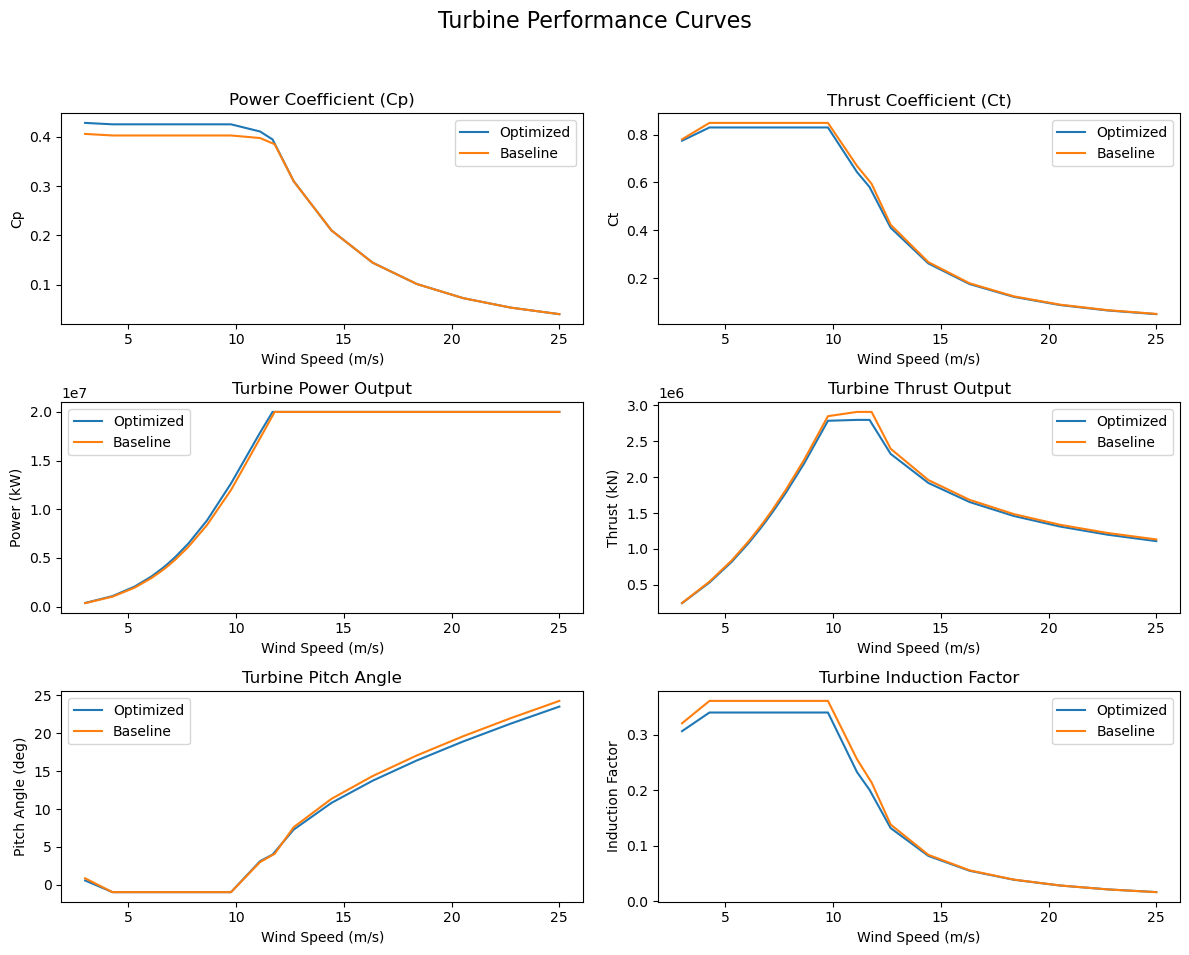

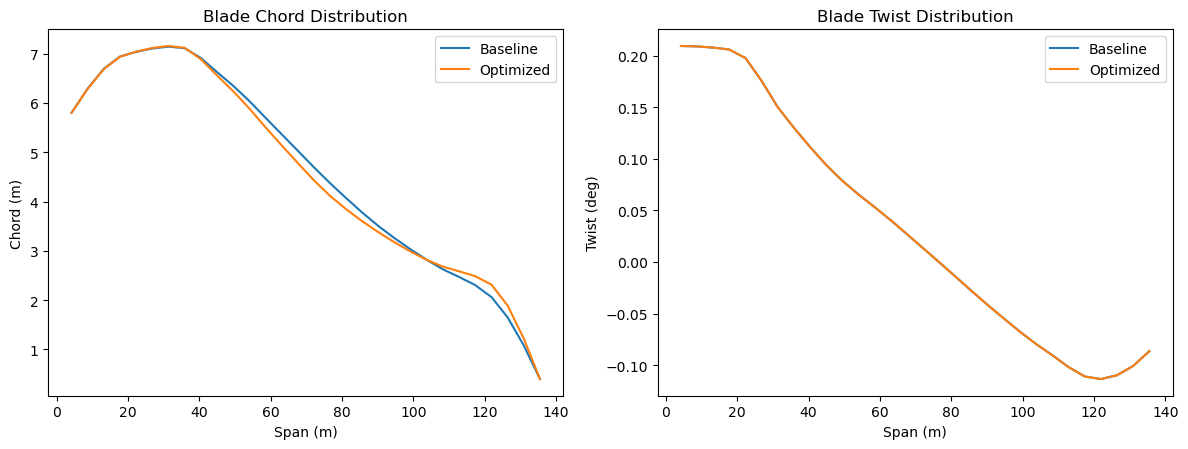

In [26]:
baseline_turb = pd.read_csv(os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder,"outputs_nonOpti/stage-1-aeroStruct-NonOptimized.csv"), index_col=0)
optimized_turb = pd.read_csv(os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder,"outputs_preCompute/stage-1-aeroStruct-aero_analysis.csv"), index_col=0)

plot_rotor_comparison(baseline_turb, optimized_turb)

## Important Considerations

### Modeling Limitations
- As discussed earlier, this optimization uses CCBlade for aerodynamic analysis, which assumes rigid blades. The performance numbers show correct trends but may not be consistent with models at higher levels of fidelity.
- For more precise performance predictions, you would need to use WEIS with OpenFAST+BeamDyn, which captures blade flexibility but is computationally expensive.

### Optimization Convergence
The optimization successfully converged in 44 iterations. We can examine the optimization history using the `log_opt.sql` file, which logs all design variables and constraints throughout the process.

## 1.2 Plot Optimization Convergence

loading /Users/dzalkind/Tools/WEIS-Eni/examples/09_model_creation_process/0_notebooks/../1_drivers/stage-1-aeroStruct/outputs_preCompute/log_opt.sql


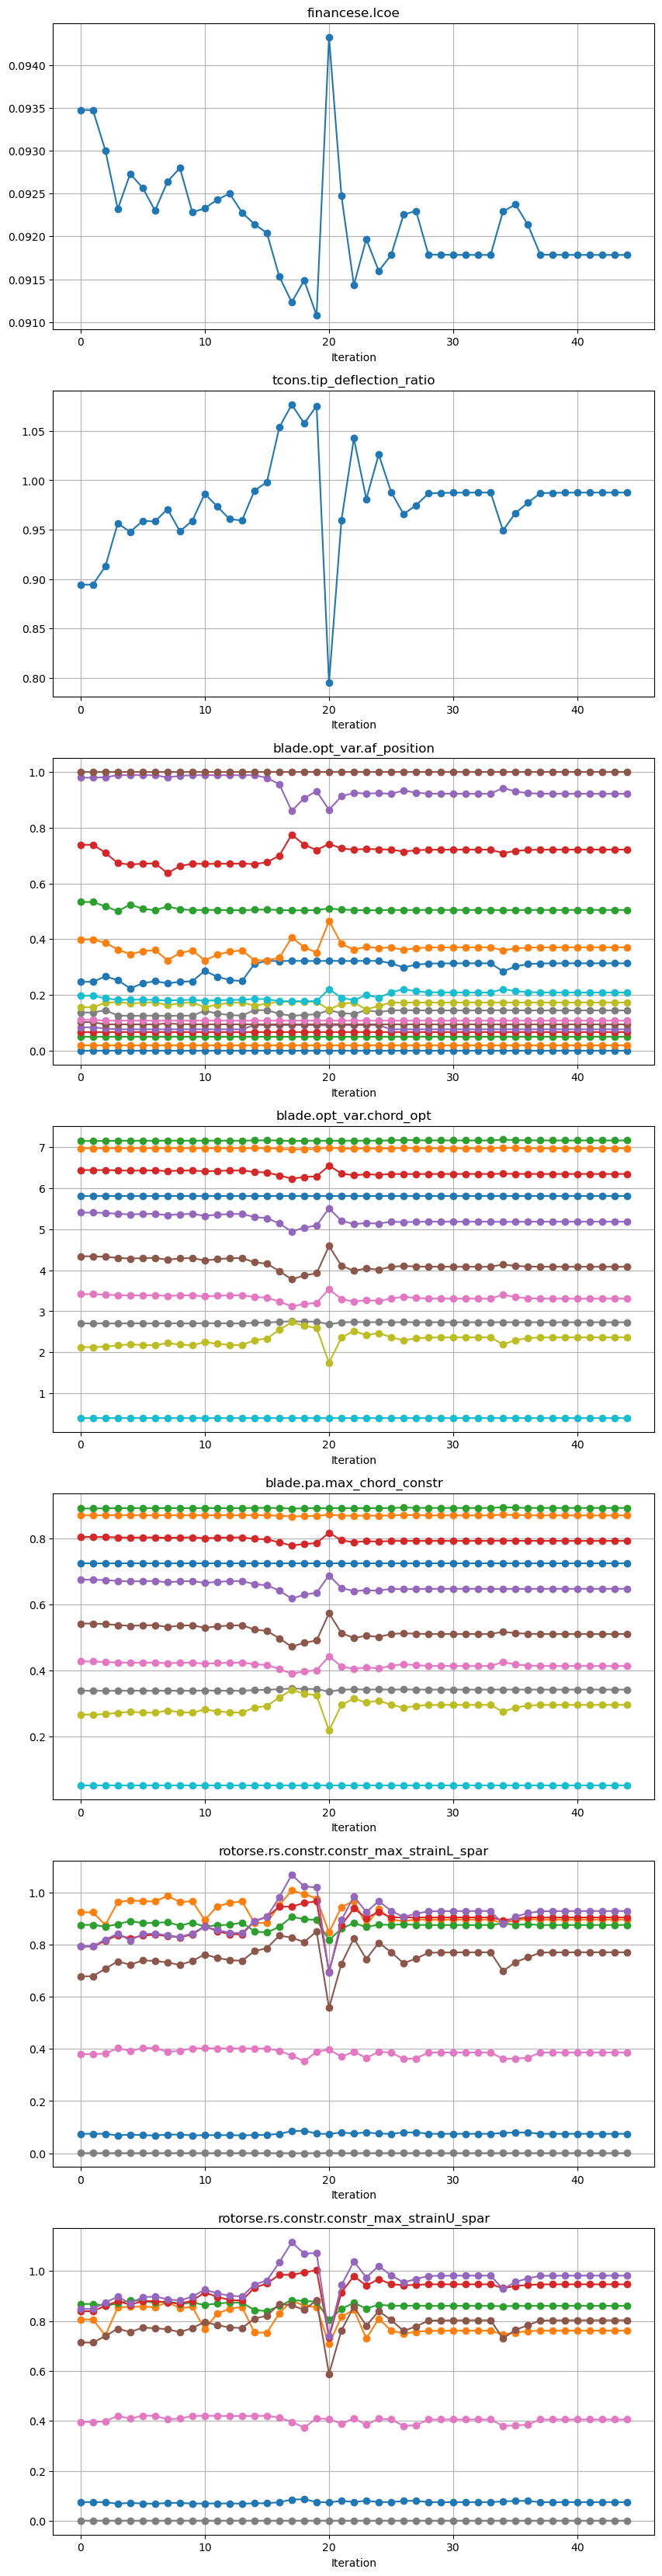

In [28]:
rec_data = load_OMsql(os.path.join(WORKSHOP_REPO, "1_drivers", stageFolder,"outputs_preCompute/log_opt.sql")) # not sure what supresses the output here
plot_convergence(rec_data, ['financese.lcoe', 'tcons.tip_deflection_ratio', 'blade.opt_var.af_position', 'blade.opt_var.chord_opt', 'blade.pa.max_chord_constr',
                            'rotorse.rs.constr.constr_max_strainL_spar', 'rotorse.rs.constr.constr_max_strainU_spar'])

# Chapter 1 Complete: Your Optimized 20MW Rotor

## What We Accomplished

Congratulations! You've successfully completed the first stage of wind turbine design optimization. Here's what we achieved in this session:

- **Baseline Analysis**: Started with the IEA 22MW floating wind turbine and established a performance baseline
- **Input File Understanding**: Explored the WEIS/WISDEM input file structure and configuration options
- **Performance Assessment**: Analyzed the baseline turbine and visualized key performance metrics from the CSV output
- **Turbine Scaling**: Modified the IEA 22MW design to create a 20MW turbine by adjusting rotor diameter and rated power
- **Rotor Optimization**: Used WISDEM to optimize chord distribution, structural properties, and airfoil positioning
- **Convergence Analysis**: Examined the optimization history using log_opt.sql and plotted convergence behavior
- **Design Comparison**: Evaluated the performance improvements between unoptimized and optimized 20MW rotors

<!-- You now have a solid foundation in WEIS optimization workflows and are ready to proceed to controller tuning and platform design in the next chapters! -->